In [32]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam


In [33]:
def penalized_loss(y_true, y_pred):
    penalty = 100.0  # This value can be adjusted
    loss = tf.where(y_pred < 0, penalty * tf.square(y_true - y_pred), tf.square(y_true - y_pred))
    return tf.reduce_mean(loss, axis=-1)

In [34]:
# Load the data
data = pd.read_csv('D:\\bachelor\\customer_36.csv')

# Preprocess the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

In [35]:
# Split the data into training and testing sets
X = data.drop('consumption', axis=1)
y = data['consumption']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Split the data into training and testing sets
# Assuming the data is hourly, 24*7 rows would make a week
X_train, X_test = X[:-48*7], X[-48*7:]
y_train, y_test = y[:-48*7], y[-48*7:]
X = pd.DataFrame(scaler_X.fit_transform(X), columns=X.columns)
y = pd.DataFrame(scaler_y.fit_transform(y.values.reshape(-1,1)), columns=[y.name])

In [36]:
# Define the architecture of the NN
model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))

d:\bachelor\BACH\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [37]:
# Compile the NN with the custom loss function
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the NN
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

Epoch 1/50


812/812 ━━━━━━━━━━━━━━━━━━━━ 2s 576us/step - loss: 359.0131
Epoch 2/50
812/812 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step - loss: 0.0181
Epoch 3/50
812/812 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - loss: 0.0144
Epoch 4/50
812/812 ━━━━━━━━━━━━━━━━━━━━ 1s 602us/step - loss: 0.0129
Epoch 5/50
812/812 ━━━━━━━━━━━━━━━━━━━━ 1s 616us/step - loss: 0.0123
Epoch 6/50
812/812 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step - loss: 0.0117
Epoch 7/50
812/812 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step - loss: 0.0118
Epoch 8/50
812/812 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step - loss: 0.0114
Epoch 9/50
812/812 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - loss: 0.0113
Epoch 10/50
812/812 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - loss: 0.0113
Epoch 11/50
812/812 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step - loss: 0.0112
Epoch 12/50
812/812 ━━━━━━━━━━━━━━━━━━━━ 1s 609us/step - loss: 0.0111
Epoch 13/50
812/812 ━━━━━━━━━━━━━━━━━━━━ 1s 617us/step - loss: 0.0109
Epoch 14/50
812/812 ━━━━━━━━━━━━━━━━━━━━ 1s 622us/step - loss: 0.0093
Epoch 15/50
812/812 ━━━━━━━━━━━━━━━━━━

In [38]:
# Evaluate the NN
loss = model.evaluate(X_test, y_test, verbose=1)
print('Test Loss: ', loss)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - loss: 0.0025   
Test Loss:  0.002949518384411931


In [39]:
# Predict solar production for the next week
next_week_prediction = model.predict(X_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [40]:
next_week_prediction = scaler_y.inverse_transform(next_week_prediction)

In [43]:
# Generate date array
end_date = pd.to_datetime('2013-06-30 23:30:00')
start_date = end_date - pd.DateOffset(hours=336/2)  # 336 half-hourly data points = 168 hours = 7 days
dates = pd.date_range(start=start_date, end=end_date, freq='30min')
# Exclude the last element from the dates array
dates = dates[:-1]

Mean Absolute Error: 0.01302703137320431


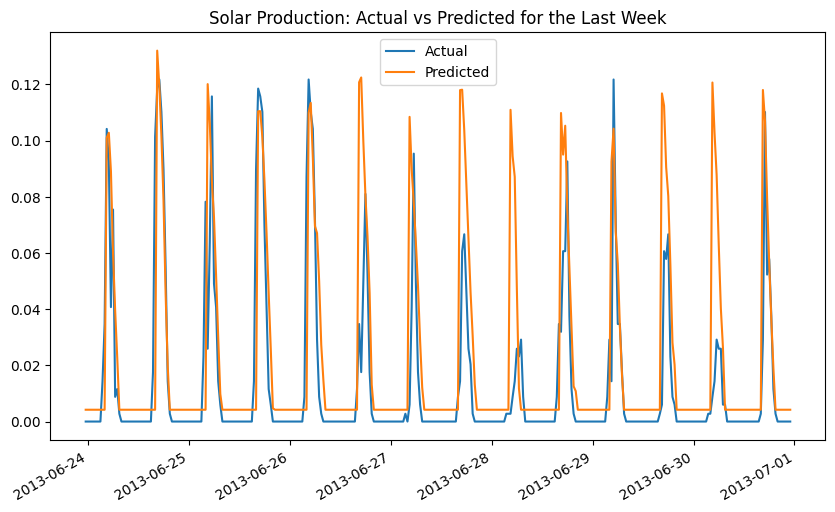

In [45]:
# Convert y_test to its original scale
y_test_original = scaler_y.inverse_transform(y_test.values.reshape(-1, 1))

# Set all negative predictions to 0
next_week_prediction = np.clip(next_week_prediction, 0, None)
# print mae
print('Mean Absolute Error:', np.mean(np.abs(y_test_original - next_week_prediction)))
plt.figure(figsize=(10, 6))
plt.plot(dates, y_test_original, label='Actual')
plt.plot(dates, next_week_prediction, label='Predicted')
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gcf().autofmt_xdate()  # Rotation
plt.legend()
plt.title('Solar Production: Actual vs Predicted for the Last Week')
plt.show()

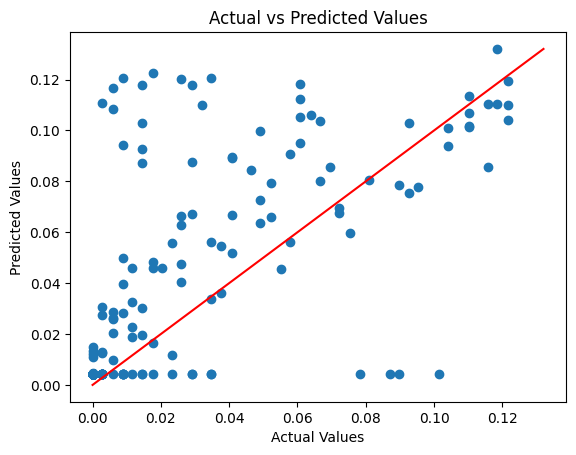

In [46]:
# Ensure both arrays are 1D
y_test_original = np.array(y_test_original).reshape(-1)
next_week_prediction = np.array(next_week_prediction).reshape(-1)

plt.scatter(y_test_original, next_week_prediction)

# Create a 45 degree line
max_value = max(max(y_test_original), max(next_week_prediction))
plt.plot([0, max_value], [0, max_value], color='red')

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')

plt.show()